In [1]:
from scipy.stats import special_ortho_group
import numpy as np
from kooplearn import EDMD
from kooplearn.data.datasets.stochastic import LinearModel
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:

true_rank = 5
dim = 20
eigs_min = -3

num_init_cond = 100
evol_time = 100
noise = 1e-5

true_eigs = 9*np.logspace(eigs_min, -1, true_rank)
true_eigs = np.concatenate([true_eigs, np.zeros(dim-true_rank)])
true_eigs = np.flip(np.sort(true_eigs))

def make_linear_system(true_rank = 5, dim = 20, noise = 1e-3, rng_seed = 0):
    eigs = 9*np.logspace(eigs_min, -1, true_rank)
    # print("Eigenvalues:")
    # for ev in eigs:
    #     print(f"{ev:.1e} \t", end='')
    eigs = np.concatenate([eigs, np.zeros(dim-true_rank)])
    Q = special_ortho_group(dim, 0).rvs(1)
    A = np.linalg.multi_dot([Q, np.diag(eigs), Q.T])

    #Consistency-check
    assert np.allclose(np.sort(np.linalg.eigvalsh(A)), np.sort(eigs))
    return LinearModel(A, noise, rng_seed)

### Principal component regression:

In [3]:
def eval_EDMD_on_lin_sys(evol_time = 100, num_init_cond = 100, EDMD_kwargs = {}):
    rng = np.random.default_rng(0)
    X0 = rng.normal(size=(num_init_cond, dim))
    lin_sys = make_linear_system(true_rank, dim, noise=noise, rng_seed=0)
    train_trajectories = lin_sys.generate(X0.T, evol_time)
    train_trajectories = np.transpose(train_trajectories, (2, 0, 1)) # (num_init_cond, evol_time, dim)
    
    fro_sq_errors = []
    eigs_errors = []

    for traj in train_trajectories:
        edmd = EDMD(**EDMD_kwargs)
        edmd.fit(traj[:-1], traj[1:])
        A_estim = np.linalg.multi_dot([edmd.U, edmd.U.T, edmd.cov_XY])
        A_true = lin_sys.A

        fro_sq_errors.append(np.linalg.norm(A_estim - A_true, ord='fro')**2)
        _eig = np.flip(np.sort(edmd.eig()))
        eigs_errors.append(_eig - true_eigs[:len(_eig)])
    
    avg_eigs_errors = np.abs(np.array(eigs_errors)).mean(axis=0)/true_eigs[:len(_eig)]
    fro_sq_error = np.array(fro_sq_errors).mean()
    return fro_sq_error, avg_eigs_errors

In [23]:
#PCR, Well Specified Rank, Least Squares
EDMD_kwargs = {
    'reduced_rank': False,
    'rank': true_rank -2,
    'tikhonov_reg': 1e-13,
    'svd_solver': 'full',
    'rng_seed': 0
}
err = []
eig_err = []
n_samples = [10, 100,  1000, 10000, 50000, 100_000]
for evol_time in tqdm(n_samples, desc="Evolving Time"):
    fro_sq_error, avg_eigs_errors = eval_EDMD_on_lin_sys(EDMD_kwargs=EDMD_kwargs, num_init_cond=10, evol_time=evol_time)
    err.append(fro_sq_error)
    eig_err.append(avg_eigs_errors)

Evolving Time: 100%|██████████| 6/6 [00:10<00:00,  1.69s/it]


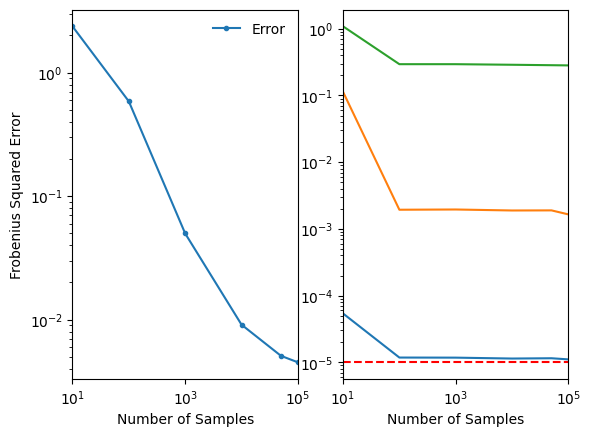

In [22]:
fig, axes = plt.subplots(ncols=2)
ax = axes[0]
ax.plot(n_samples, err, '.-', label="Error")
ax.set_ylabel("Frobenius Squared Error")
ax.set_xlabel("Number of Samples")
ax.set_xscale('log')
ax.set_yscale('log')
ax.margins(x=0)
ax.legend(frameon=False)

ax = axes[1]
ax.axhline(noise, color='r', linestyle='--')
# for i in range(true_rank):
#     ax.axhline(true_eigs[i], color='k', linestyle='--', alpha=0.5)
ax.plot(n_samples, eig_err)

ax.set_xlabel("Number of Samples")
ax.set_xscale('log')
ax.set_yscale('log')
ax.margins(x=0)


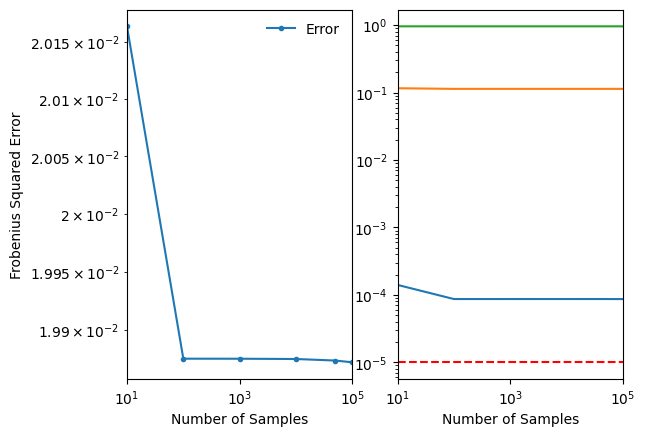

In [24]:
fig, axes = plt.subplots(ncols=2)
ax = axes[0]
ax.plot(n_samples, err, '.-', label="Error")
ax.set_ylabel("Frobenius Squared Error")
ax.set_xlabel("Number of Samples")
ax.set_xscale('log')
ax.set_yscale('log')
ax.margins(x=0)
ax.legend(frameon=False)

ax = axes[1]
ax.axhline(noise, color='r', linestyle='--')
# for i in range(true_rank):
#     ax.axhline(true_eigs[i], color='k', linestyle='--', alpha=0.5)
ax.plot(n_samples, eig_err)

ax.set_xlabel("Number of Samples")
ax.set_xscale('log')
ax.set_yscale('log')
ax.margins(x=0)
